# Titanic: Machine Learning from Disaster

# Feature Engineering

## 1 - Setup

### 1.1 - Import Packages

In [45]:
import sys
from os import path
sys.path.append( path.dirname( path.dirname( path.abspath('__file__') ) ) )

import fancyimpute
import numpy as np
import matplotlib.pyplot as plt
from misc.data_io import get_train_df, get_test_df, get_paths
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
import warnings

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### 1.2 - Load Data

#### VARIABLE DESCRIPTIONS:
* survival:        Survival(0 = No; 1 = Yes)
* pclass:          Passenger Class(1 = 1st; 2 = 2nd; 3 = 3rd)
* name:            Name
* sex:             Sex
* age:             Age
* sibsp:           Number of Siblings/Spouses Aboard
* parch:           Number of Parents/Children Aboard
* ticket:          Ticket Number
* fare:            Passenger Fare
* cabin:           Cabin
* embarked:        Port of Embarkation(C = Cherbourg; Q = Queenstown; S = Southampton)

In [3]:
train_data = get_train_df()
test_data = get_test_df()
full_data = pd.concat([train_data, test_data]).reset_index(drop=True)
full_data['Pclass'] = full_data['Pclass'].astype('category')
full_data['Embarked'] = full_data['Embarked'].astype('category')
full_data['Sex'] = full_data['Sex'].astype('category')
full_data.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


### 1.2 - Variables Statistical Description

Generate various summary statistics, excluding NaN values. It's possible to notice that there are a lot of missing values for cabin and age and also a few for embarked and fare.

In [4]:
# Statistical description of the data
full_data.describe()

/home/rafael/anaconda3/envs/titanic/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age,Fare,Parch,PassengerId,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,328.000000,0.000000,NaN
50%,NaN,NaN,0.000000,655.000000,0.000000,NaN
75%,NaN,NaN,0.000000,982.000000,1.000000,NaN
max,80.000000,512.329200,9.000000,1309.000000,8.000000,1.000000


In [5]:
# Count how many NaN values there are in each column
len(full_data) - full_data.count()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [6]:
# Passengers with missing values for Embarked and Fare.
full_data[full_data.drop(['Age','Cabin','Survived'], axis=1).isnull().any(axis=1)]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


## 2- Feature Engineering

In [7]:
# Creating an empty dataframe for new features.
new_features = pd.DataFrame()

### 2.1 - Name

Thera are two interesting features we can extract from the name field: the passenger's surname and title. When we first split the name column we have the following titles:

In [8]:
df1 = full_data['Name']
split_df = df1.str.split(', ',expand=True,n=1)
new_features['Surname'] = split_df[0]
new_features['Title'] = split_df[1].str.split('. ',expand=True,n=1)[0]
new_features.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Mme           1
Capt          1
th            1
Dona          1
Don           1
Jonkheer      1
Lady          1
Sir           1
Name: Title, dtype: int64

After a little processing we can reduce the number of the titles to just 5 classes.

In [9]:
new_features.loc[new_features.Title == 'Mme', 'Title'] = 'Mr'
new_features.loc[new_features.Title == 'Ms', 'Title'] = 'Miss'
new_features.loc[new_features.Title == 'Mlle', 'Title'] = 'Miss'
new_features.loc[new_features.Title == 'Mme', 'Title'] = 'Mr'
new_features.loc[new_features.Title.isin(['Rev', 'Dr', 'Col', 'Major', 'Lady', 'Don', 'Capt', 'Sir', 'Dona', 
                                                'Jonkheer','th']), 'Title'] = 'Rare'
new_features.Title.value_counts()

Mr        758
Miss      264
Mrs       197
Master     61
Rare       29
Name: Title, dtype: int64

The plot below shows the strong relationship between the title of a passenger and it's survival rate.

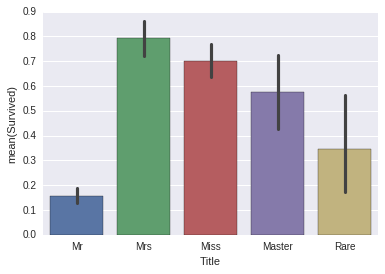

In [10]:
sns.barplot(x='Title', y='Survived', data=pd.concat([new_features.Title, full_data.Survived], axis=1, join='inner'))

The next interesting thing to look at is the passenger's surname. There ara lots of different surnames, but it is possible to notice some repetition, that we can infer that is due to a family on board. Now that we have some information linking passengers from the same family it makes sence to verify whether there are any survivals from a given family, thus the feature SurvivingRelatives was created.

In [11]:
new_features.Surname.value_counts()[0:15]

Sage         11
Andersson    11
Asplund       8
Goodwin       8
Davies        7
Rice          6
Smith         6
Johnson       6
Brown         6
Ford          6
Fortune       6
Carter        6
Skoog         6
Panula        6
Ryerson       5
Name: Surname, dtype: int64

In [12]:
# Verifies if there are anyone charing the same surname that survived. For test data it is considered that a 
# passenger survived if, and only if, the passenger is female.
surname_df = pd.DataFrame()
surname_df.loc[:,'Surname'] = new_features.Surname
surname_df.loc[:,'Survived'] = pd.concat([train_data.Survived, test_data.Sex.replace(['male','female'],[0,1])], axis=0).reset_index(drop=True)
surname_df.loc[:,'SurvivingRelatives'] = 0
for i, row in surname_df.iterrows():
    if any((surname_df.drop(i).Surname==row.Surname) & (surname_df.drop(i).Survived==1)):
        surname_df.SurvivingRelatives.iloc[i]=1

/home/rafael/anaconda3/envs/titanic/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


As we can see, having a surviving relative increases the survival rate in almost 50%.

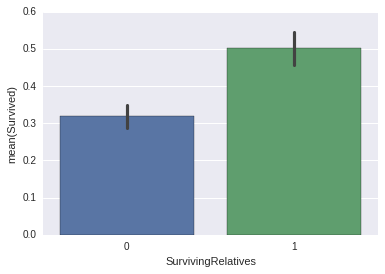

In [13]:
sns.barplot(x=surname_df.SurvivingRelatives, y=surname_df.Survived)

In [14]:
new_features.loc[:,'SurvivingRelatives'] = surname_df.SurvivingRelatives
new_features = new_features.drop('Surname',axis=1)

### 2.2 - Ticket

The ticket variable is, sometimes composed by some kind of code before the numbers. Those are listed below.

In [15]:
full_data.Ticket.tolist()
full_data.Ticket[full_data.Ticket=='LINE'].Ticket = 'LINE '
foo = lambda x: pd.Series([i for i in reversed(x.upper().replace('.','').split(' '))])
df1 = full_data['Ticket'].apply(foo)
df1.rename(columns={0:'tk_num',1:'tk_type',2:'tk_o'},inplace=True)
df1 = df1.fillna(value='None')
df1 = pd.concat([df1.tk_type, full_data.Survived], axis=1, join='inner')
df1.tk_type.value_counts()

None        961
PC           92
CA           68
A/5          25
SOTON/OQ     24
SC/PARIS     19
W/C          15
2            15
FCC           9
A/4           9
C             8
SOC           7
STON/O2       7
SO/PP         7
SC/AH         4
PP            4
SOTON/O2      3
A5            3
FC            3
SC/A4         2
WEP           2
SC            2
SW/PP         2
P/PP          2
WE/P          2
SO/C          1
BASLE         1
SOP           1
A4            1
SP            1
FA            1
SCO/W         1
LP            1
STON/OQ       1
A/S           1
AQ/4          1
CA/SOTON      1
AQ/3          1
SC/A3         1
Name: tk_type, dtype: int64

After some processing it was possible to reduce the amount of classes to just a few. Unfortunatly only a few of those classes actually present significaly differences on survival rate. 

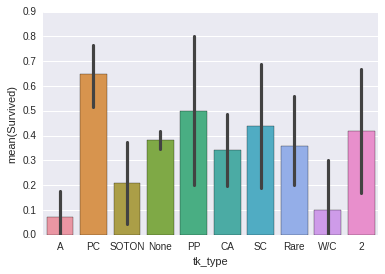

In [16]:
df1.loc[(df1.tk_type.str.contains('STON', na=False))|(df1.tk_type.str.contains('SOTON', na=False)),'tk_type']='SOTON'
df1.loc[df1.tk_type.str.contains('SC', na=False),'tk_type']='SC'
df1.loc[df1.tk_type.str.contains('PP', na=False),'tk_type']='PP'
df1.loc[df1.tk_type.isin(['A/5','A5','A/4','A4']),'tk_type'] = 'A'
df1.loc[~df1.tk_type.isin(['PC','PP','CA','SC','SOTON','A','2','W/C','None']),'tk_type'] = 'Rare'
sns.barplot(x='tk_type', y='Survived', data=df1)

### 2.3 - Deck

The last information that we can extract is the deck letter, in the cabin variable. We can notice that those who have the cabin variable filled up have higher survival rates than those who don't. The diference between decks doesn't look statistically significant.

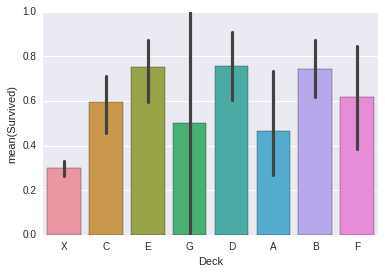

In [17]:
new_features.loc[:,'Deck'] = full_data.Cabin.fillna(value='X').astype(str).str[0]
new_features.loc[new_features['Deck']=='T', 'Deck'] = 'X'
sns.barplot(x='Deck', y='Survived', data=pd.concat([new_features.Deck, full_data.Survived], axis=1, join='inner'))

In [18]:
preproc_data = pd.concat([full_data.drop(['PassengerId','Cabin', 'Ticket', 'Name'], axis=1), new_features], axis=1, join='inner')
preproc_data['FamilySize'] = preproc_data.Parch + preproc_data.SibSp + 1
preproc_data = preproc_data.drop(['Parch','SibSp'],axis=1)
final_data = pd.get_dummies(preproc_data)
final_data.dtypes

Age                   float64
Fare                  float64
Survived              float64
SurvivingRelatives      int64
FamilySize              int64
Embarked_C            float64
Embarked_Q            float64
Embarked_S            float64
Pclass_1              float64
Pclass_2              float64
Pclass_3              float64
Sex_female            float64
Sex_male              float64
Title_Master          float64
Title_Miss            float64
Title_Mr              float64
Title_Mrs             float64
Title_Rare            float64
Deck_A                float64
Deck_B                float64
Deck_C                float64
Deck_D                float64
Deck_E                float64
Deck_F                float64
Deck_G                float64
Deck_X                float64
dtype: object

## 3 - Imputation of missing values

### 3.1 - Embarked

There are two passangers with a missing value for Embarked:

In [19]:
preproc_data.iloc[[61,829]]

,Age,Embarked,Fare,Pclass,Sex,Survived,Title,SurvivingRelatives,Deck,FamilySize
61,38.0,NaN,80.0,1,female,1.0,Miss,0,B,1
829,62.0,NaN,80.0,1,female,1.0,Mrs,0,B,1


To find out the, value we can look at the variables with the highest absolute correlation with Embarked variable. Those are Pclass and Fare, and they are the same for both passengers.

In [20]:
corr=final_data.corr().abs().sort_values(by='Embarked_C',ascending=False)
corr.Embarked_C[corr.Embarked_C>0.2]

Embarked_C    1.000000
Embarked_S    0.775441
Pclass_1      0.325722
Fare          0.286269
Deck_X        0.259501
Name: Embarked_C, dtype: float64

Comparing the median of the fares payed in the three ports we find out that Cherbourg has a fare more similar with the fare that the passengers payed.

Median (C): 76.7292
Median (Q): 90.0
Median (S): 52.0


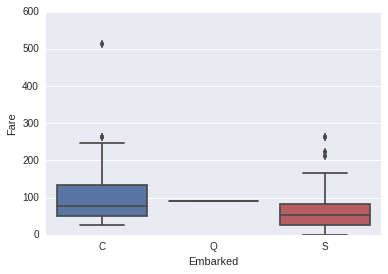

In [21]:
sns.boxplot(y='Fare',x='Embarked',data=preproc_data[preproc_data.Pclass==1])
print ('Median (C):',preproc_data[(preproc_data.Pclass==1)&(preproc_data.Embarked=='C')].Fare.median())
print ('Median (Q):',preproc_data[(preproc_data.Pclass==1)&(preproc_data.Embarked=='Q')].Fare.median())
print ('Median (S):',preproc_data[(preproc_data.Pclass==1)&(preproc_data.Embarked=='S')].Fare.median())

In [22]:
final_data.loc[61, 'Embarked_C'] = 1
final_data.loc[829, 'Embarked_C'] = 1

preproc_data.loc[61, 'Embarked'] = 'C'
preproc_data.loc[829, 'Embarked'] = 'C'

### 3.2 - Fare

There is one passanger with a missing value for Fare:

In [23]:
preproc_data.iloc[[1043]]

,Age,Embarked,Fare,Pclass,Sex,Survived,Title,SurvivingRelatives,Deck,FamilySize
1043,60.5,S,NaN,3,male,NaN,Mr,0,X,1


To find out the value, we can look at the variable with the highest absolute correlation with Fare, this is Pclass. 

In [24]:
corr=final_data.corr().abs().sort_values(by='Fare',ascending=False)
corr.Fare[corr.Fare>0.3]

Fare        1.000000
Pclass_1    0.600031
Deck_X      0.507787
Pclass_3    0.419752
Deck_C      0.401382
Deck_B      0.393751
Name: Fare, dtype: float64

Next we look at the variable with highest absolute correlation with Fare given that the Pclass o the passenger is 3. This variable is FamilySize.

In [25]:
corr=final_data[final_data.Pclass_3==1].corr().abs().sort_values(by='Fare',ascending=False)
corr.Fare[corr.Fare>0.3]

Fare                  1.000000
FamilySize            0.818544
SurvivingRelatives    0.321021
Name: Fare, dtype: float64

Looking at the PDF of Fare given that Pclass is 3 and FamilySize is 1 it's reasonable to say that the Fare this passenger payed is the median of the distribution. 

Median: 7.8542


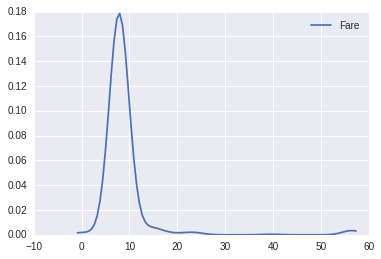

In [28]:
sns.kdeplot(final_data[(final_data.Pclass_3==1)&(final_data.FamilySize==1)].Fare.dropna())
print ('Median:',final_data[(final_data.Pclass_3==1)&(final_data.FamilySize==1)].Fare.median())

In [29]:
final_data.loc[1043,'Fare'] = final_data[(final_data.Pclass_3==1)&(final_data.FamilySize==1)].Fare.median()
preproc_data.loc[1043,'Fare'] = final_data.loc[1043,'Fare'] 

### 3.3 - Age

There are 263 passangers with a missing value for Age:

In [30]:
no_age = final_data[final_data.Age.isnull()]
print ('Passengers missing Age:',len(no_age))
no_age.head()

Passengers missing Age: 263


,Age,Fare,Survived,SurvivingRelatives,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,...,Title_Mrs,Title_Rare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
5,NaN,8.4583,0.0,1,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,NaN,13.0000,1.0,0,1,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,NaN,7.2250,1.0,0,1,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26,NaN,7.2250,0.0,0,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28,NaN,7.8792,1.0,0,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


First of all lets look the variables with the highest absolute correlation wit Age. The plot confirms that Title is very related to Age.

In [31]:
corr = final_data.corr().abs().sort_values(by='Age',ascending=False)
corr.Age[corr.Age>0.2]

Age             1.000000
Pclass_1        0.393198
Title_Master    0.391259
Pclass_3        0.337069
Deck_X          0.287797
Title_Miss      0.282792
FamilySize      0.240229
Title_Mrs       0.217502
Name: Age, dtype: float64

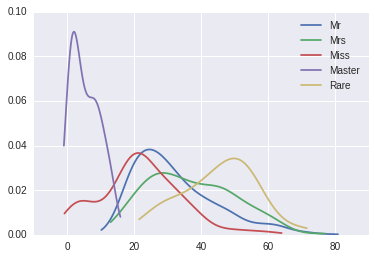

In [32]:
sns.kdeplot(preproc_data[preproc_data.Title=='Mr'].Age.dropna(), label='Mr')
sns.kdeplot(preproc_data[preproc_data.Title=='Mrs'].Age.dropna(), label='Mrs')
sns.kdeplot(preproc_data[preproc_data.Title=='Miss'].Age.dropna(), label='Miss')
sns.kdeplot(preproc_data[preproc_data.Title=='Master'].Age.dropna(), label='Master')
sns.kdeplot(preproc_data[preproc_data.Title=='Rare'].Age.dropna(), label='Rare')

To impute missing values for Age lets use Multiple Imputation by Chained Equation (MICE). Check http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/ for more information about it.

In [33]:
filled_soft = fancyimpute.MICE(init_fill_method='random', n_imputations=10).complete(np.array(final_data[['Age','Pclass_1','Title_Master','Pclass_3','Title_Miss','FamilySize','Deck_X','Title_Mrs']]))

[MICE] Completing matrix with shape (1309, 8)
[MICE] Starting imputation round 1/20, elapsed time 0.003
[MICE] Starting imputation round 2/20, elapsed time 0.016
[MICE] Starting imputation round 3/20, elapsed time 0.017
[MICE] Starting imputation round 4/20, elapsed time 0.019
[MICE] Starting imputation round 5/20, elapsed time 0.020
[MICE] Starting imputation round 6/20, elapsed time 0.021
[MICE] Starting imputation round 7/20, elapsed time 0.021
[MICE] Starting imputation round 8/20, elapsed time 0.022
[MICE] Starting imputation round 9/20, elapsed time 0.023
[MICE] Starting imputation round 10/20, elapsed time 0.028
[MICE] Starting imputation round 11/20, elapsed time 0.029
[MICE] Starting imputation round 12/20, elapsed time 0.030
[MICE] Starting imputation round 13/20, elapsed time 0.031
[MICE] Starting imputation round 14/20, elapsed time 0.032
[MICE] Starting imputation round 15/20, elapsed time 0.033
[MICE] Starting imputation round 16/20, elapsed time 0.034
[MICE] Starting imp

The plot below shows how the distribution of the imputed values is very similar to the original distribution.

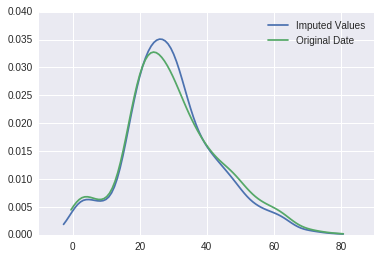

In [34]:
age_series = pd.DataFrame(filled_soft)[0]
sns.kdeplot(age_series, label='Imputed Values')
sns.kdeplot(final_data.Age.dropna(), label='Original Date')

In [35]:
final_data.loc[:,'Age'] = age_series
preproc_data.loc[:,'Age'] = age_series

In [36]:
train_preproc = final_data[:len(train_data)]
test_preproc = final_data[len(train_data):].drop('Survived',axis=1)

Now that all the pre-process is defined there can be defined a function 'preprocess()' that will receive a dataframe and apply all the steps discussed so far. This function was created and used by me on the 'model_engineering' notebook.

## 4 - Model

The focus of this notebook is exploratory analysis and feature engineering, but lets create a simple Logistic Regression model just to have a feeling on what results we can expect from the features created so far.

In [37]:
X_train = train_preproc.drop('Survived', axis=1)
y_train = train_preproc.Survived
X_test = test_preproc

Lets leave the default values of scikit-learn and just evaluate de cross-validation accuracy of the model.

In [40]:
clf = LogisticRegression()
cv = cross_val_score(clf, X_train, y_train, cv=10) 
print ('Cross-Validation Accuracy:',mean(cv),'+-',std(cv))

Cross-Validation Accuracy: 0.831731926002 +- 0.031330958922


Then we fit a model with the full dataset.

In [41]:
clf.fit(X_train,y_train)
y_test = clf.predict(X_test)

Finally we can output the data for kaggle submission

In [48]:
out = pd.DataFrame()
out.loc[:,'PassengerId'] = test_data.PassengerId
out.loc[:,'Survived'] = pd.Series(y_test, dtype='int')
paths = get_paths()
out.to_csv(path.join(paths['root'], paths['submission_dir'], 'simple_logreg.csv'), index=False)

This output ranked 0.80383 on kaggle's leaderboard. Not bad for a model that simple!